In [13]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [100]:
con = sqlite3.connect('database.sqlite')
cursor = con.cursor()
cursor.execute("SELECT * FROM Tweets LIMIT 10")
# print(cursor.fetchall())

The table contains a sample of tweets related to US domestic flights in 2015. There is a column with the tweet text content and another column that indicates if the sentiment of that text was either positive, negative or neutral. There is also a column that states the confidence level of the detected sentiment for each comment. The comments are related to one of six airlines ( United, US Airways, American, Southwest, Delta, Virgin America).

For the comments that were classified as negative, there is a column which states what was the reason for classifying the comment as negative. 

In [83]:
data = pd.read_sql_query("SELECT * FROM Tweets",con)
# Add the column of positive sentiment
data['positive_sentiment'] = 'no'
data.loc[data['airline_sentiment']=='positive', 'positive_sentiment'] = 'yes'
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,positive_sentiment
0,567588278875213824,neutral,1.0,,,Delta,,JetBlueNews,,0,@JetBlue's new CEO seeks the right balance to ...,,2015-02-16 23:36:05 -0800,USA,Sydney,no
1,567590027375702016,negative,1.0,Can't Tell,0.6503,Delta,,nesi_1992,,0,@JetBlue is REALLY getting on my nerves !! 😡😡 ...,,2015-02-16 23:43:02 -0800,undecided,Pacific Time (US & Canada),no
2,567591480085463040,negative,1.0,Late Flight,0.346,United,,CPoutloud,,0,@united yes. We waited in line for almost an h...,,2015-02-16 23:48:48 -0800,"Washington, DC",,no
3,567592368451248130,negative,1.0,Late Flight,1,United,,brenduch,,0,@united the we got into the gate at IAH on tim...,,2015-02-16 23:52:20 -0800,,Buenos Aires,no
4,567594449874587648,negative,1.0,Customer Service Issue,0.3451,Southwest,,VahidESQ,,0,@SouthwestAir its cool that my bags take a bit...,,2015-02-17 00:00:36 -0800,"Los Angeles, CA",Pacific Time (US & Canada),no


In [110]:
data.shape

(14485, 16)

Let's get a count of the number of comments for each airline and each sentiment.  There are 14485 comments in total.

In [39]:
sent_count = data.groupby(['airline', 'airline_sentiment']).count()['tweet_id'].to_frame('sentiment_count')
sent_count

sentiment_count
airline        airline_sentiment                 
American       negative                      1864
               neutral                        433
               positive                       307
Delta          negative                       955
               neutral                        723
               positive                       544
Southwest      negative                      1186
               neutral                        664
               positive                       570
US Airways     negative                      2263
               neutral                        381
               positive                       269
United         negative                      2633
               neutral                        697
               positive                       492
Virgin America negative                       181
               neutral                        171
               positive                       152

Let's see how many comments/reviews each airline recieved.

In [84]:
airline_count = data.groupby(['airline']).count()['tweet_id'].sort_values(ascending=False)
airline_count.to_frame('airline_count')

,airline_count
airline,
United,3822
US Airways,2913
American,2604
Southwest,2420
Delta,2222
Virgin America,504


Now we can compute the proportion of comments that were positive, neutral and negative for each airline.

In [85]:
sent_pct = sent_count.div(airline_count, level='airline', axis=0)
sent_pct.rename(columns={'sentiment_count':'sentiment_proportion'})

sentiment_proportion
airline        airline_sentiment                      
American       negative                       0.715822
               neutral                        0.166283
               positive                       0.117896
Delta          negative                       0.429793
               neutral                        0.325383
               positive                       0.244824
Southwest      negative                       0.490083
               neutral                        0.274380
               positive                       0.235537
US Airways     negative                       0.776862
               neutral                        0.130793
               positive                       0.092345
United         negative                       0.688906
               neutral                        0.182365
               positive                       0.128728
Virgin America negative                       0.359127
               neutral                        0.339286
               positive                       0.301587

1. Which airline has the most negative sentiment?

The airline with most of the negative comments is United, however, proportionally US Airways recieved more negative comments.

In [71]:
# The greatest number of negative comments
most_neg = sent_count.query('airline_sentiment == "negative"').max().values[0]
sent_count.query('sentiment_count == @most_neg').index.get_level_values('airline')[0]

'United'

In [72]:
# The airline that has proportionally the greatest number of negative comments
most_neg = sent_pct.query('airline_sentiment == "negative"').max().values[0]
sent_pct.query('sentiment_count == @most_neg').index.get_level_values('airline')[0]

'US Airways'

The above answer can be confirmed with the following plots. Most comments on twitter were negative, wich means that they are likely to be complaints. Actually, positive comments were a small proportion of the total comments made on twitter.

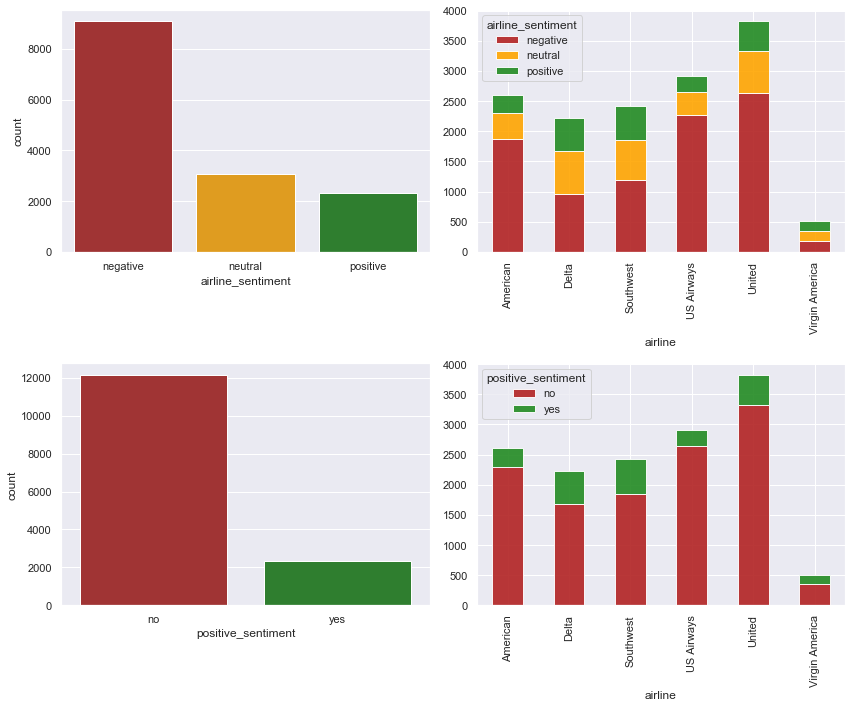

In [105]:
fig, axs = plt.subplots(2,2, figsize=(12,10))
colors = ['firebrick', 'orange','forestgreen']
colors2 = ['firebrick', 'forestgreen']

sns.countplot(x='airline_sentiment', data=data, ax=axs[0,0], palette=colors, order = ['negative','neutral','positive'])

data_stack = data.groupby(['airline', 'airline_sentiment']).size().reset_index().pivot(columns='airline_sentiment', index='airline', values=0)
data_stack.plot(kind='bar', stacked=True, ax=axs[0,1], color=colors, alpha=0.9)

sns.countplot(x='positive_sentiment', data=data, ax=axs[1,0], palette=['firebrick','forestgreen'], order = ['no','yes'])

data_stack = data.groupby(['airline', 'positive_sentiment']).size().reset_index().pivot(columns='positive_sentiment', index='airline', values=0)
data_stack.plot(kind='bar', stacked=True, ax=axs[1,1], colors=colors2, alpha=0.9)

plt.tight_layout()

All airlines have comments which have a confidence level of 1.0. That means that the sentiment classifier is certain that the comment presents the given sentiment.

In [86]:
# Max sentiment confidence per airline
conf_max =  data.groupby(['airline', 'airline_sentiment']).max()['airline_sentiment_confidence']
conf_max.to_frame('max_sentiment_confidence')

max_sentiment_confidence
airline        airline_sentiment                          
American       negative                                1.0
               neutral                                 1.0
               positive                                1.0
Delta          negative                                1.0
               neutral                                 1.0
               positive                                1.0
Southwest      negative                                1.0
               neutral                                 1.0
               positive                                1.0
US Airways     negative                                1.0
               neutral                                 1.0
               positive                                1.0
United         negative                                1.0
               neutral                                 1.0
               positive                                1.0
Virgin America negative                                1.0
               neutral                                 1.0
               positive                                1.0

The minimum confidence level for each airline and each sentiment is shown in the following table. The lower values for all cases seem to be around 0.3 or 0.35

In [87]:
# Min sentiment confidence per airline
conf_min =  data.groupby(['airline', 'airline_sentiment']).min()['airline_sentiment_confidence']
conf_min.to_frame('min_sentiment_confidence')

min_sentiment_confidence
airline        airline_sentiment                          
American       negative                             0.3394
               neutral                              0.3367
               positive                             0.3487
Delta          negative                             0.3435
               neutral                              0.3363
               positive                             0.3373
Southwest      negative                             0.3437
               neutral                              0.3353
               positive                             0.3356
US Airways     negative                             0.3400
               neutral                              0.3421
               positive                             0.3419
United         negative                             0.3398
               neutral                              0.3350
               positive                             0.3366
Virgin America negative                             0.3573
               neutral                              0.3483
               positive                             0.3482

Let convert the confidence level for the sentiment to a categorial variable by assigning the values greater than 0.8 to `high`, levels lower than 0.4 to `low` and the rest to `med`. On most cases, the cases with low confidence values seem to be scarce.

In [115]:
# Create a new column with the categorical bining of the confidence column
data['confidence_level'] = pd.cut(data['airline_sentiment_confidence'], [0,0.4,0.8,1], labels=['low','med','high'])

# Count for each airline the condifence levels
conf_level =  data.groupby(['airline', 'airline_sentiment', 'confidence_level']).count()['airline_sentiment_confidence']
conf_level.to_frame('confidence_level_count')

confidence_level_count
airline        airline_sentiment confidence_level                        
American       negative          low                                    4
                                 med                                  303
                                 high                                1557
               neutral           low                                   15
                                 med                                  200
                                 high                                 218
               positive          low                                    6
                                 med                                  101
                                 high                                 200
Delta          negative          low                                   17
                                 med                                  249
                                 high                                 689
               neutral           low                                   23
                                 med                                  326
                                 high                                 374
               positive          low                                   13
                                 med                                  193
                                 high                                 338
Southwest      negative          low                                   10
                                 med                                  264
                                 high                                 912
               neutral           low                                   23
                                 med                                  302
                                 high                                 339
               positive          low                                   15
                                 med                                  167
                                 high                                 388
US Airways     negative          low                                   10
                                 med                                  350
                                 high                                1903
               neutral           low                                   14
                                 med                                  177
                                 high                                 190
               positive          low                                   13
                                 med                                   89
                                 high                                 167
United         negative          low                                   20
                                 med                                  491
                                 high                                2122
               neutral           low                                   22
                                 med                                  355
                                 high                                 320
               positive          low                                   20
                                 med                                  174
                                 high                                 298
Virgin America negative          low                                    2
                                 med                                   50
                                 high                                 129
               neutral           low                                    4
                                 med                                   75
                                 high                                  92
               positive          low                                    4
                                 med                   

Now let's talk about the reasons for writing negative comments. The most common complaint was related to customer service issues. The next most common reason for the complaints was that the flights were late.

In [88]:
# The most common reasons when having a negative sentiment
reason_count = (data['negativereason'].value_counts().sort_values(ascending=False))[1::]
reason_count.to_frame('negative_reason_count')

,negative_reason_count
Customer Service Issue,2885
Late Flight,1650
Can't Tell,1176
Cancelled Flight,829
Lost Luggage,719
Bad Flight,575
Flight Booking Problems,523
Flight Attendant Complaints,475
longlines,177
Damaged Luggage,73


Almost half of complaints where related to customer service issue or late flights as shown in the next plot.

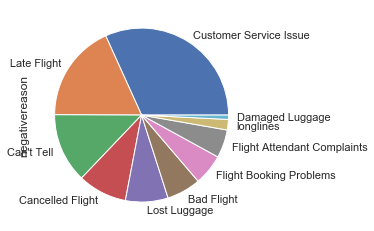

In [109]:
reason_prop = reason_count/reason_count.sum()
reason_prop.plot(kind='pie')